# Introduccion
#### En este proyecto, exploramos la aplicación de diversos modelos de procesos estocásticos para la optimización y toma de decisiones bajo incertidumbre, implementados utilizando el lenguaje de programación Python.



*   ***Enumeraciones Sucesivas:*** Este método implica la exploración exhaustiva de todas las posibles políticas de decisión para encontrar la óptima, evaluando cada una en función de criterios específicos de rendimiento.
*   ***Mejoramiento de Políticas:*** Utilizamos técnicas iterativas para mejorar continuamente una política de decisión inicial, basándonos en la retroalimentación del rendimiento observado.


*   ***Mejoramiento de Políticas con Descuento:*** Similar al mejoramiento de políticas, pero considerando la influencia del tiempo mediante un factor de descuento que prioriza los beneficios a corto plazo sobre los futuros.
*   ***Aproximaciones Sucesivas:*** Implementamos métodos iterativos para mejorar una política de decisión a través de aproximaciones sucesivas de la función objetivo.


*   ***Programación por Política Lineal (PPL):*** Formulamos el problema de decisión estocástica como un problema de programación lineal, representando las políticas de decisión de manera lineal y optimizándolas bajo restricciones específicas.


Cada modelo se implementa utilizando bibliotecas y herramientas disponibles en Python, aprovechando su flexibilidad y eficiencia computacional. Este enfoque nos permite no solo explorar la teoría detrás de cada método, sino también desarrollar soluciones prácticas y escalables para problemas reales de optimización bajo incertidumbre.








# Librerías usadas para plantear y resolver el MPL

In [ ]:
!pip install pulp
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, LpStatus, value

#Función para plantear y resolver el modelo de programación lineal

Ejemplo del resultado que imprime:

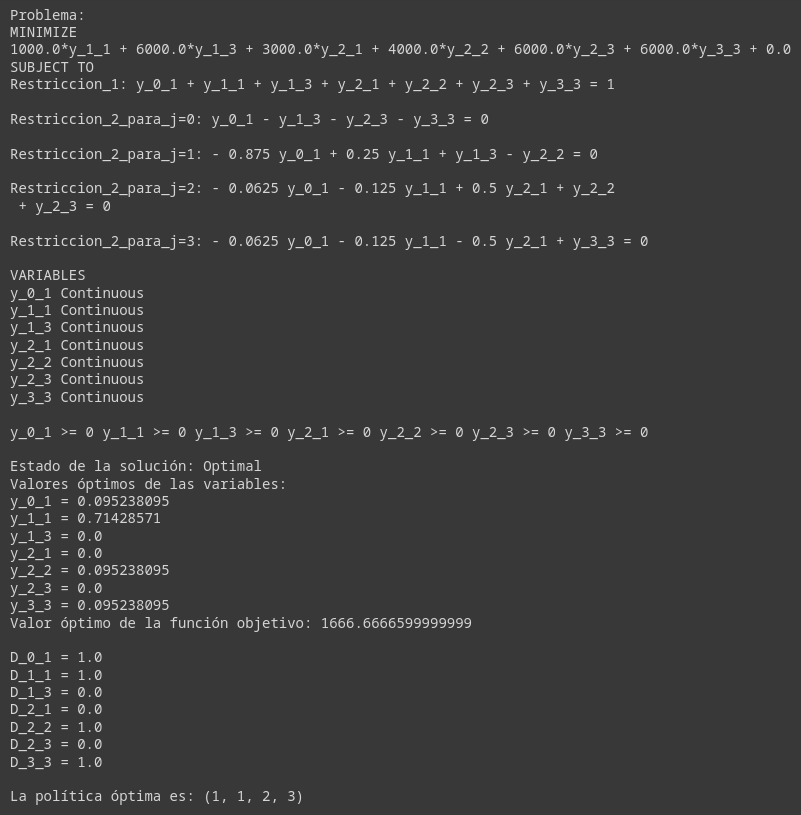

## Ejemplo de matrices válidas

Matrices de transición:  \\

Matriz 1:  \\
[0.0, 0.875, 0.0625, 0.0625]  \\
[0.0, 0.75, 0.125, 0.125]  \\
[0.0, 0.0, 0.5, 0.5]  \\
[0.0, 0.0, 0.0, 0.0]  \\

Matriz 2:  \\
[0.0, 0.0, 0.0, 0.0]  \\
[0.0, 0.0, 0.0, 0.0]  \\
[0.0, 1.0, 0.0, 0.0]  \\
[0.0, 0.0, 0.0, 0.0]  \\

Matriz 3:  \\
[0.0, 0.0, 0.0, 0.0]  \\
[1.0, 0.0, 0.0, 0.0]  \\
[1.0, 0.0, 0.0, 0.0]  \\
[1.0, 0.0, 0.0, 0.0]  \\

Matriz de costos:  \\
[0.0, None, None]  \\
[1000.0, None, 6000.0]  \\
[3000.0, 4000.0, 6000.0]  \\
[None, None, 6000.0]  \\

Es importante poner None en la matriz de costos en los elementos que no tienen asignado un costo porque con base en eso se definen las variables de decisión del modelo.



In [ ]:
def plantear_y_resolver_MPL(matrices_transicion: list = None, matriz_costos: list = None, objetivo: str = None) -> None:
  """
  Plantea el modelo de programacion lineal, lo resuelve e imprime los resultados.

  Parameters
  ----------
  matrices_transicion : list
    Lista de matrices de transicion por cada desicion.
  matriz_costos : list
    Matriz de costos.
  objetivo : str
    Los unicos valores posibles son 'max' o 'min'.

  """
  # Si las matices no tienen elementos para hacer el planteamiento o no se especifico el objetivo
  if matrices_transicion is None or matriz_costos is None or matrices_transicion == [] or matriz_costos == [] or objetivo not in ('max', 'min'):
    pass

  # Crear variables para hacer las iteraciones que contruiran el modelo
  M = len(matrices_transicion[0])
  K = len(matrices_transicion)
  # Matriz para calcular los valores de D
  D = [[None for _ in range(K)] for _ in range(M)]

  # Crear un problema de programacion lineal
  if objetivo == 'max':
    problema = LpProblem("Problema", LpMaximize)
  else:
    problema = LpProblem("Problema", LpMinimize)

  # Crear un diccionario para almacenar las variables continuas
  variables = {}
  D_variables = {}

  # Iterar sobre la matriz de costos para definir las variables continuas
  for i in range(len(matriz_costos)):
    for j in range(len(matriz_costos[i])):
        if matriz_costos[i][j] is not None:
            # Definir una variable continua para la posicion (i, j)
            var_name = f'y_{i}_{j + 1}'
            variables[(i, j)] = LpVariable(var_name, lowBound = 0)
            D_variables[(i, j)] = f'D_{i}_{j + 1}'

  # Funcion objetivo (contemplando solamente las variables definidas)
  problema += lpSum(matriz_costos[i][k] * variables[(i, k)] for i in range(M) for k in range(K) if (i, k) in variables), "Funcion Objetivo"

  # Las suma de las diferentes y_{ik} debe ser igual a 1
  restriccion_suma_1 = lpSum(variables[(i, k)] for i in range(M) for k in range(K) if (i, k) in variables)
  problema += (restriccion_suma_1 == 1), f"Restriccion_1"

  # j = 0, 1, ..., M
  for j in range(M):
    # Primera sumatoria, pero antes se debe primero confirmar que la variable continua se ha definido para integrarlo a la suma
    restriccion1 = lpSum(variables[(j, k)] for k in range(K) if (j, k) in variables)

    # Segunda sumatoria
    restriccion2 = lpSum(matrices_transicion[k][i][j] * variables[(i, k)] for i in range(M) for k in range(K) if (i, k) in variables)

    # Combinar ambas restricciones en una sola
    problema += (restriccion1 - restriccion2 == 0), f"Restriccion_2_para_j={j}"

  print(problema)

  for i in variables.values():
    print(i, '>= 0', end = ' ')

  print('\n')

  # Resolver el problema
  problema.solve()

  # Variables utilizadas para recorrer las soluciones y almacenarlas en el lugar indicado de la matriz D
  variable_keys = list(variables.keys())
  cont_keys = 0

  # Imprimir el estado de la solucion
  print("Estado de la solución:", LpStatus[problema.status])

  # Imprimir los valores optimos de las variables
  print("Valores óptimos de las variables:")
  for variable in problema.variables():
      print(f"{variable.name} = {variable.varValue}")
      ind = variable_keys[cont_keys]
      D[ind[0]][ind[1]] = variable.varValue
      cont_keys = cont_keys + 1

  # Imprimir el valor optimo de la funcion objetivo
  print("Valor óptimo de la función objetivo:", end = ' ')
  print(value(problema.objective), end = '\n\n')

  # Calcular los valores de D
  for ij in range(M):
    suma_fila = sum(elemento for elemento in D[ij] if elemento is not None)
    for k in range(K):
      if D[ij][k] is not None:
        D[ij][k] = D[ij][k] / suma_fila
        print(f"{D_variables[(ij, k)]} = {D[ij][k]}")

  politica_optima = tuple(fila.index(1) + 1 for fila in D if 1 in fila)

  print(f"\nLa política óptima es: {politica_optima}")

# Fuera

### Librerias

In [ ]:
import itertools
import numpy as np
from fractions import Fraction

### Definicion de funciones


#### Enumeraciones sucesivas

In [ ]:
def calcular_costo_total(matriz_costos, matriz_combinaciones, numero_estados, numero_decisiones):
    """
    Calculates the total cost for each combination of decisions given a cost matrix and a combinations matrix.
    Args:
        matriz_costos (list of list of int/float): Matrix containing the costs for each state and decision.
        matriz_combinaciones (list of list of int): Matrix containing combinations of states and decisions.
        numero_estados (int): Number of possible states.
        numero_decisiones (int): Number of possible decisions.
    Returns:
        list of float: List of total costs for each combination.
        list of list of int: List of original combinations.

    """
    # List to store the total costs of each combination and list to store the combinations
    costos_totales = []
    combinaciones = []
    # Iterate over each combination in the combinations matrix
    for combinacion in matriz_combinaciones:
        costo_combinacion = 0
        # Calculate the total cost for the current combination
        for i in range(len(combinacion) // 2):
            j_indice = combinacion[i] - 1
            i_indice = i
            costo = matriz_costos[i_indice][j_indice] * combinacion[len(combinacion) // 2 + i]
            costo_combinacion += costo  # Add the current cost to the total cost of the combination
        # Add the total cost and the combination to their respective lists
        costos_totales.append(costo_combinacion)
        combinaciones.append(combinacion)
    # Return the list of total costs and the list of combinations
    return costos_totales, combinaciones

def generar_vector_b(numero_estados):
    """
    Generates a vector 'b' with a given number of states, where the last element is set to 1 and all other elements are set to 0.
    Args:
        numero_estados (int): The number of states, which determines the length of the vector.
    Returns:
        numpy.ndarray: A vector of length 'numero_estados' with the last element set to 1 and all other elements set to 0.
    """
    # Create a vector of zeros with length 'numero_estados'
    vector_b = np.zeros(numero_estados)
    # Set the last element of the vector to 1
    vector_b[-1] = 1
    # Return the resulting vector
    return vector_b

def transformar_matriz_R(matriz_R):
    """
    Transforms a given matrix 'R' by first transposing it and then subtracting 1 from each diagonal element of the transposed matrix.
    Args:
        matriz_R (list of list of int/float): The original matrix 'R' to be transformed.
    Returns:
        list of list of int/float: The transformed matrix after transposition and diagonal modification.
    """
    # Transpose the matrix 'R'
    matriz_transpuesta = [list(columna) for columna in zip(*matriz_R)]
    # Subtract 1 from each diagonal element of the transposed matrix
    for i in range(len(matriz_transpuesta)):
        matriz_transpuesta[i][i] -= 1

    # Return the transformed matrix
    return matriz_transpuesta

def actualizar_ultima_fila(matriz):
    """
    Updates the last row of a given matrix by setting all its elements to 1.
    Args:
        matriz (list of list of int/float): The matrix to be updated.
    Returns:
        list of list of int/float: The updated matrix with the last row elements set to 1.
    """
    # Get the last row of the matrix
    ultima_fila = matriz[-1]
    # Set all elements in the last row to 1
    matriz[-1] = [1] * len(ultima_fila)
    # Return the updated matrix
    return matriz

def generar_matrices_por_R(estados_validos, matrices, vector_estados_validos):
    """
    Generates a list of matrices based on valid states and decisions.
    Args:
        estados_validos (list): List of valid states.
        matrices (list of list of list): A list of matrices where each matrix corresponds to a different decision.
        vector_estados_validos (list of list): A list of lists, where each sublist contains valid decisions for a corresponding state.
    Returns:
        list of list of list: A list of matrices, where each matrix is formed based on a combination of decisions for valid states.
    """
    # List to store the resulting matrices
    matrices_por_R = []

    # Iterate over all combinations of valid decisions for each state
    for combinacion in itertools.product(*vector_estados_validos):

        # Create a new matrix for the current combination of decisions
        matriz_por_R = []

        # Iterate over each state and its corresponding decision in the combination
        for estado, decision in enumerate(combinacion):

            # Select the row from the matrix corresponding to the decision
            fila_seleccionada = matrices[decision - 1][estado]

            # Append the selected row to the new matrix
            matriz_por_R.append(fila_seleccionada)

        # Append the new matrix to the list of resulting matrices
        matrices_por_R.append(matriz_por_R)

    # Return the list of resulting matrices
    return matrices_por_R

def calcular_soluciones_y_costos(matrices_por_R, combinaciones_estados, matriz_costos, numero_estados, numero_decisiones):
    """
    Calculates solutions and costs for a given set of matrices and state combinations.
    Args:
        matrices_por_R (list of list of list of float): List of matrices transformed for each combination of decisions.
        combinaciones_estados (list of list of int): List of state combinations.
        matriz_costos (list of list of float): Cost matrix for each state and decision.
        numero_estados (int): Number of possible states.
        numero_decisiones (int): Number of possible decisions.
    Returns:
        None
    """
    # List to store the solutions
    matriz_soluciones = []
    for i, matriz_por_R in enumerate(matrices_por_R):
        try:
            # Transform the matrix
            matriz_transformada = transformar_matriz_R(matriz_por_R)
            matriz_transformada = np.array(matriz_transformada, dtype=float)
            matriz_transformada = actualizar_ultima_fila(matriz_transformada)

            # Generate the vector b
            vector_b = generar_vector_b(len(matriz_transformada))

            # Solve the system of equations
            solucion = np.linalg.solve(matriz_transformada, vector_b)

            # Append the solution to the list of solutions
            matriz_soluciones.append(list(solucion))
        except np.linalg.LinAlgError:
            # In case of a linear algebra error, append a zero solution
            matriz_soluciones.append([0] * len(matriz_por_R[0]))
    # List to store the combinations of states and their corresponding solutions
    matriz_combinaciones_soluciones = []

    for i, combinacion in enumerate(combinaciones_estados):
        solucion_actual = matriz_soluciones[i]
        combinacion_solucion = list(combinacion) + list(solucion_actual)
        matriz_combinaciones_soluciones.append(combinacion_solucion)

    # Print the combinations of states and their corresponding solutions
    print("Matriz de Combinaciones de Estados y Soluciones:")
    for fila in matriz_combinaciones_soluciones:
        print(fila)

    # Calculate the total costs for the state and solution combinations
    costos_totales, combinaciones = calcular_costo_total(matriz_costos, matriz_combinaciones_soluciones, numero_estados, numero_decisiones)

    # Print the costs of the policies
    print("Costos de las políticas:")
    for fila in costos_totales:
        print(fila)

    # Find and print the maximum and minimum total costs and their corresponding combinations
    maximo_costo = max(costos_totales)
    minimo_costo = min(costos_totales)
    print("\nMáximo costo total:", maximo_costo)
    print("Combinación correspondiente:", combinaciones[costos_totales.index(maximo_costo)])
    print("\nMínimo costo total:", minimo_costo)
    print("Combinación correspondiente:", combinaciones[costos_totales.index(minimo_costo)])

#### Mejoramiento de politicas

In [ ]:
def reemplazar_ultima_columna_por_valor(matriz, valor):
    """
    Replaces the last column of a given matrix with a specified value.
    Args:
        matriz (numpy.ndarray): The matrix to be transformed.
        valor (int or float): The value to replace in the last column of the matrix.
    Returns:
        numpy.ndarray: The transformed matrix with the last column replaced by the specified value.
    """
    # Create a copy of the input matrix
    matriz_transformada = np.copy(matriz)
    # Get the number of rows and columns of the matrix
    num_filas, num_columnas = matriz_transformada.shape
    # Replace the last column with the specified value
    matriz_transformada[:, num_columnas - 1] = valor
    # Return the transformed matrix
    return matriz_transformada

def transformar_matriz_R2(matriz_R):
    """
    Transforms a given matrix 'R' by subtracting 1 from each diagonal element.
    Args:
        matriz_R (list of list of int/float): The original matrix 'R' to be transformed.
    Returns:
        list of list of int/float: The transformed matrix after subtracting 1 from each diagonal element.
    """
    # Create a deep copy of the input matrix
    matriz_transformada = [fila[:] for fila in matriz_R]
    # Subtract 1 from each diagonal element of the copied matrix
    for i in range(len(matriz_transformada)):
        matriz_transformada[i][i] -= 1
    # Return the transformed matrix
    return matriz_transformada

def generar_matriz_combinaciones(combinaciones_estados, matriz_soluciones):
    """
    Generates a matrix combining state combinations with their corresponding solutions.
    Args:
        combinaciones_estados (list of list of int): List of state combinations.
        matriz_soluciones (list of list of float): List of solutions corresponding to each state combination.
    Returns:
        list of list: A matrix where each row combines a state combination with its corresponding solution.
    """
    # List to store the combined state and solution combinations
    matriz_combinaciones_soluciones = []

    # Iterate over each state combination and its corresponding solution
    for combinacion, solucion in zip(combinaciones_estados, matriz_soluciones):
        # Combine the state combination with its solution
        combinacion_solucion = list(combinacion) + list(solucion)
        # Append the combined combination-solution to the result matrix
        matriz_combinaciones_soluciones.append(combinacion_solucion)
    # Return the matrix of combined combinations and solutions
    return matriz_combinaciones_soluciones

def calcular_g(matrices, vector_V, matriz_costos, objetivo):
    """
    Calculates decisions based on matrices, a vector, costs, and an optimization objective.
    Args:
        matrices (list of numpy.ndarray): List of matrices for each decision.
        vector_V (numpy.ndarray): Vector representing state values.
        matriz_costos (list of list of float): Cost matrix for each state and decision.
        objetivo (str): Optimization objective, either 'maximizar' or 'minimizar'.
    Returns:
        str: String representation of decisions based on the objective ('maximizar' or 'minimizar').
    """
    numero_estados = len(vector_V)
    numero_decisiones = len(matrices)
    decisiones = ''

    for i in range(numero_estados):
        valores_g = []
        decisiones_posibles = []

        for k in range(numero_decisiones):
            matriz_R = np.array(matrices[k])
            suma_productos = np.sum(matriz_R[i] * vector_V)
            g_ik = suma_productos - vector_V[i] + matriz_costos[i][k]
            valores_g.append((k, g_ik))

            if not np.all(matriz_R[i] == 0):
                decisiones_posibles.append((k + 1, g_ik))

        if objetivo == 'maximizar':
            decision = max(decisiones_posibles, key=lambda x: x[1])[0]
        elif objetivo == 'minimizar':
            decision = min(decisiones_posibles, key=lambda x: x[1])[0]
        else:
            raise ValueError("Invalid objective option. It must be either 'maximizar' or 'minimizar'.")

        decisiones += str(decision)

    return decisiones

def buscar_decisiones(matrices, vector_V, matriz_costos, numero_iteraciones, hola, objetivo, combinaciones_estados, matriz_soluciones):
    """
    Iteratively searches for solutions based on given matrices, vector, costs, and state combinations.
    Args:
        matrices (list of numpy.ndarray): List of matrices for each decision.
        vector_V (numpy.ndarray): Vector representing state values.
        matriz_costos (list of list of float): Cost matrix for each state and decision.
        numero_iteraciones (int): Number of iterations to search for solutions.
        hola (int or str): Initial input or decision sequence.
        objetivo (str): Optimization objective, either 'maximizar' or 'minimizar'.
        combinaciones_estados (list of list of int): List of state combinations.
        matriz_soluciones (list of list of float): List of solutions corresponding to each state combination.
    Returns:
        None
    """
    for i in range(numero_iteraciones):
        if i == 0:
            entrada = hola
        else:
            entrada = decisiones

        combinacion_busqueda = [int(d) for d in str(entrada)]
        matriz_combinaciones_soluciones = generar_matriz_combinaciones(combinaciones_estados, matriz_soluciones)

        if combinacion_busqueda in combinaciones_estados:
            indice_division = len(matriz_combinaciones_soluciones[0]) // 2
            solucion_encontrada = None
            g = None

            for fila in matriz_combinaciones_soluciones:
                combinacion_actual = fila[:indice_division]
                if combinacion_actual == combinacion_busqueda:
                    g = fila[-1]
                    fila[-1] = 0
                    solucion_encontrada = fila[indice_division:]
                    break

            if solucion_encontrada is not None:
                print("Solución encontrada:", solucion_encontrada)
                print("Valor de g:", g)

                decisiones = calcular_g(matrices, solucion_encontrada, matriz_costos, objetivo)
                print("Decisiones:", decisiones)

                if decisiones == entrada:
                    print("La salida de decisiones coincide con 'Iteracion'.")
                    break
            else:
                print("La combinación no se encontró en la matriz.")
        else:
            print("La combinación no existe en la matriz de combinaciones de estados.")

def verificar_secuencia_existente(secuencia, matriz_combinaciones_estados):
    """
    Checks if a sequence of integers exists in a list of sequences.
    Args:
        secuencia (int or str): Sequence of integers to be checked.
        matriz_combinaciones_estados (list of list of int): List of sequences to search within.
    Returns:
        bool: True if the sequence exists in matriz_combinaciones_estados, False otherwise.
    """
    secuencia_enteros = [int(d) for d in str(secuencia)]
    if secuencia_enteros in matriz_combinaciones_estados:
        return True
    else:
        return False

#### Mejoramiento de políticas con descuento:





In [ ]:
def reemplazar_ultima_columna_por_valor(matriz, valor):
    """
    Replaces the last column of a given matrix with a specified value.
    Args:
        matriz (numpy.ndarray): The matrix to be transformed.
        valor (int or float): The value to replace in the last column of the matrix.
    Returns:
        numpy.ndarray: The transformed matrix with the last column replaced by the specified value.
    """
    # Create a copy of the input matrix
    matriz_transformada = np.copy(matriz)
    # Get the number of rows and columns of the matrix
    num_filas, num_columnas = matriz_transformada.shape
    # Replace the last column with the specified value
    matriz_transformada[:, num_columnas - 1] = valor
    # Return the transformed matrix
    return matriz_transformada

def transformar_matriz_R2(matriz_R):
    """
    Transforms a given matrix 'R' by subtracting 1 from each diagonal element.
    Args:
        matriz_R (list of list of int/float): The original matrix 'R' to be transformed.
    Returns:
        list of list of int/float: The transformed matrix after subtracting 1 from each diagonal element.
    """
    # Create a deep copy of the input matrix
    matriz_transformada = [fila[:] for fila in matriz_R]
    # Subtract 1 from each diagonal element of the copied matrix
    for i in range(len(matriz_transformada)):
        matriz_transformada[i][i] -= 1
    # Return the transformed matrix
    return matriz_transformada

def generar_matriz_combinaciones(combinaciones_estados, matriz_soluciones):
    """
    Generates a matrix combining state combinations with their corresponding solutions.
    Args:
        combinaciones_estados (list of list): List of state combinations.
        matriz_soluciones (list of list): List of solutions corresponding to each state combination.
    Returns:
        list of list: A matrix where each row combines a state combination with its corresponding solution.
    """
    matriz_combinaciones_soluciones = []

    # Iterate through each pair of state combination and solution
    for combinacion, solucion in zip(combinaciones_estados, matriz_soluciones):
        # Combine the state combination list with the solution list
        combinacion_solucion = list(combinacion) + list(solucion)
        # Append the combined list to the result matrix
        matriz_combinaciones_soluciones.append(combinacion_solucion)
    return matriz_combinaciones_soluciones

def calcular_g2(matrices, vector_V, matriz_costos, objetivo, alfa):
    """
    Calculates decisions based on matrices, a vector, costs, an optimization objective,
    and a scaling factor alfa.
    Args:
        matrices (list of numpy.ndarray): List of matrices for each decision.
        vector_V (list or numpy.ndarray): Vector representing state values.
        matriz_costos (list of list of float): Cost matrix for each state and decision.
        objetivo (str): Optimization objective, either 'maximizar' or 'minimizar'.
        alfa (float): Scaling factor for the sum of products in the decision calculation.
    Returns:
        str: String representation of decisions based on the objective ('maximizar' or 'minimizar').
    """

    vector_V = np.array(vector_V)
    numero_estados = len(vector_V)
    numero_decisiones = len(matrices)
    decisiones = ''
    for i in range(numero_estados):
        valores_g = []
        decisiones_posibles = []
        for k in range(numero_decisiones):
            matriz_R = np.array(matrices[k])
            suma_productos = np.sum(matriz_R[i] * vector_V)
            g_ik = alfa * suma_productos + matriz_costos[i][k]
            valores_g.append((k, g_ik))

            if not np.all(matriz_R[i] == 0):
                decisiones_posibles.append((k + 1, g_ik))

        if objetivo == 'maximizar':
            decision = max(decisiones_posibles, key=lambda x: x[1])[0]
        elif objetivo == 'minimizar':
            decision = min(decisiones_posibles, key=lambda x: x[1])[0]
        else:
            raise ValueError("Invalid objective option. It must be either 'maximizar' or 'minimizar'.")

        decisiones += str(decision)

    return decisiones

def buscar_decisiones2(matrices, vector_V, matriz_costos, numero_iteraciones, hola, objetivo, combinaciones_estados, matriz_soluciones, alfa):
    """
    Iteratively searches for decisions based on state matrices, state values, costs,
    an optimization objective, initial input, and a scaling factor.

    Args:
        matrices (list of numpy.ndarray): List of matrices for each decision.
        vector_V (list or numpy.ndarray): Vector representing state values.
        matriz_costos (list of list of float): Cost matrix for each state and decision.
        numero_iteraciones (int): Number of iterations to perform the search.
        hola (int or str): Initial input or sequence of decisions.
        objetivo (str): Optimization objective, either 'maximizar' or 'minimizar'.
        combinaciones_estados (list of list): List of state combinations.
        matriz_soluciones (list of list): List of solutions corresponding to each state combination.
        alfa (float): Scaling factor for the sum of products in the decision calculation.
    Returns:
        None
    """
    for i in range(numero_iteraciones):
        if i == 0:
            entrada = hola
        else:
            entrada = decisiones

        combinacion_busqueda = [int(d) for d in str(entrada)]
        matriz_combinaciones_soluciones = generar_matriz_combinaciones(combinaciones_estados, matriz_soluciones)

        if combinacion_busqueda in combinaciones_estados:
            indice_division = len(matriz_combinaciones_soluciones[0]) // 2
            solucion_encontrada = None

            for fila in matriz_combinaciones_soluciones:
                combinacion_actual = fila[:indice_division]
                if combinacion_actual == combinacion_busqueda:
                    solucion_encontrada = fila[indice_division:]
                    break

            if solucion_encontrada is not None:
                print("Solución encontrada:", solucion_encontrada)
                decisiones = calcular_g2(matrices, solucion_encontrada, matriz_costos, objetivo, alfa)
                print("Decisiones:", decisiones)

                if decisiones == entrada:
                    print("La salida de decisiones coincide con 'Iteracion'.")
                    break
            else:
                print("La combinación no se encontró en la matriz de combinaciones de estados.")
        else:
            print("La combinación no existe en la matriz de combinaciones de estados.")

def verificar_secuencia_existente(secuencia, matriz_combinaciones_estados):
    """
    Checks if a sequence of integers exists within a matrix of state combinations.
    Args:
        secuencia (int or str): Sequence of integers to be checked.
        matriz_combinaciones_estados (list of list): Matrix of state combinations, where each inner list represents a state combination.
    Returns:
        bool: True if the sequence exists in matriz_combinaciones_estados, False otherwise.
    """
    secuencia_enteros = [int(d) for d in str(secuencia)]
    # Check if the sequence of integers exists in matriz_combinaciones_estados
    if secuencia_enteros in matriz_combinaciones_estados:
        return True
    else:
        return False

def multiplicar_matriz(matriz, factor):
    """
    Multiplies each element of a matrix by a specified factor.
    Args:
        matriz (list of list): Matrix to be multiplied, where each inner list represents a row.
        factor (int or float): Factor to multiply each element of the matrix.
    Returns:
        list of list: Transformed matrix where each element has been multiplied by the factor.
    """
    matriz_transformada = []
    # Iterate through each row of the matrix
    for fila in matriz:
        # Multiply each element of the row by the factor and create a transformed row
        fila_transformada = [elemento * factor for elemento in fila]
        # Append the transformed row to the transformed matrix
        matriz_transformada.append(fila_transformada)
    return matriz_transformada

#### Sucesivas

In [ ]:
def encontrar_decision_minima(matriz):
    """
    Finds the minimum decision and its corresponding cost for each row in the given matrix.
    Args:
        matriz (list of list): Matrix where each inner list represents a row containing decision costs.
    Returns:
        tuple: A tuple containing two lists:
               - decisiones_minimas: List of minimum decisions (1-indexed) for each row. None if no valid cost.
               - costos_minimos: List of minimum costs found for each row. None if no valid cost.
    """
    decisiones_minimas = []
    costos_minimos = []

    # Iterate through each row in the matrix
    for fila in matriz:
        # Filter out None values and get valid costs and their corresponding indices
        costos_validos = [(costo, idx) for idx, costo in enumerate(fila) if costo is not None]

        if costos_validos:
            # Find the minimum cost and its index
            costo_minimo, indice_minimo = min(costos_validos, key=lambda x: x[0])
            decisiones_minimas.append(indice_minimo + 1)  # Convert index to decision (1-indexed)
            costos_minimos.append(costo_minimo)  # Store the found minimum cost
        else:
            # If no valid costs, append None for decision and cost
            decisiones_minimas.append(None)
            costos_minimos.append(None)

    return decisiones_minimas, costos_minimos

def convertir_a_floats2(matriz):
    """
    Converts a matrix of numeric values, including fractions, into floats.

    Args:
        matriz (list of list): Matrix where each inner list represents a row containing numeric values.
    Returns:
        list of list: Transformed matrix where each numeric value has been converted to float.
    """
    nueva_matriz = []
    # Iterate through each row in the matrix
    for fila in matriz:
        # Convert each value in the row to float if it's not already a float
        nueva_fila = [float(valor) if not isinstance(valor, float) else valor for valor in fila]
        nueva_matriz.append(nueva_fila)
    return nueva_matriz

def encontrar_decision_extremo(matriz, objetivo):
    """
    Finds the extreme decision (maximum or minimum) and its corresponding cost for each row in the given matrix.
    Args:
        matriz (list of list): Matrix where each inner list represents a row containing decision costs.
        objetivo (str): Objective to maximize or minimize the decision costs. Should be 'maximizar' or 'minimizar'.
    Returns:
        tuple: A tuple containing two lists:
               - decisiones_extremas: List of extreme decisions (1-indexed) for each row. None if no valid cost.
               - costos_extremos: List of extreme costs found for each row. None if no valid cost.

    Raises:
        ValueError: If objetivo is neither 'maximizar' nor 'minimizar'.
    """
    decisiones_extremas = []
    costos_extremos = []
    # Iterate through each row in the matrix
    for fila in matriz:
        # Filter out None values and get valid costs and their corresponding indices
        costos_validos = [(costo, idx) for idx, costo in enumerate(fila) if costo is not None]

        if costos_validos:
            if objetivo.lower() == "maximizar":
                # Find the maximum cost and its index
                costo_extremo, indice_extremo = max(costos_validos, key=lambda x: x[0])
            elif objetivo.lower() == "minimizar":
                # Find the minimum cost and its index
                costo_extremo, indice_extremo = min(costos_validos, key=lambda x: x[0])
            else:
                raise ValueError("El objetivo debe ser 'maximizar' o 'minimizar'.")
            decisiones_extremas.append(indice_extremo + 1)  # Convert index to decision (1-indexed)
            costos_extremos.append(costo_extremo)  # Store the found extreme cost
        else:
            # If no valid costs, append None for decision and cost
            decisiones_extremas.append(None)
            costos_extremos.append(None)
    return decisiones_extremas, costos_extremos

def calcular_V_prima(V0, C, matrices_R, objetivo):
    """
    Calculates the updated value vector V_prima and the corresponding optimal decisions based on the given parameters.
    Args:
        V0 (list): Initial value vector containing numeric values.
        C (list of list): Cost matrix where each inner list represents costs associated with decisions. Can contain None for invalid costs.
        matrices_R (list of list of list): List of matrices where each matrix represents decision impact on states.
        objetivo (str): Objective to maximize or minimize the decision impact. Should be 'maximizar' or 'minimizar'.
    Returns:
        tuple: A tuple containing two lists:
               - V_prima (list): Updated value vector after considering decision impacts.
               - decisiones (list): List of optimal decisions (1-indexed) corresponding to each state in V_prima.
    Raises:
        ValueError: If objetivo is neither 'maximizar' nor 'minimizar'.
    Notes:
        - The function handles cases where C[i][k] is None by ignoring them in the extremum calculation.
        - The optimal decision (decisiones) corresponds to the index of the optimal value in V_prima.

    """
    n = len(V0)
    V_prima = []
    decisiones = []

    # Iterate through each state i
    for i in range(n):
        resultados = []

        # Iterate through each decision k and its associated matrix_R
        for k, matriz_R in enumerate(matrices_R):
            suma = 0.0

            # Calculate the sum of decision impacts on state i
            for j in range(n):
                suma += matriz_R[i][j] * V0[j]

            # Handle cases where C[i][k] is None
            if C[i][k] is not None:
                resultados.append(C[i][k] + suma)
            else:
                resultados.append(None)

        # Find the extremum (maximum or minimum) ignoring None values
        if objetivo.lower() == "maximizar":
            extremo = max((resultado, k) for k, resultado in enumerate(resultados) if resultado is not None)
        elif objetivo.lower() == "minimizar":
            extremo = min((resultado, k) for k, resultado in enumerate(resultados) if resultado is not None)
        else:
            raise ValueError("El objetivo debe ser 'maximizar' o 'minimizar'.")

        # Append the extremum value to V_prima and its corresponding decision to decisiones
        V_prima.append(extremo[0])
        decisiones.append(extremo[1] + 1)  # Convert index to decision (1-indexed)

    return V_prima, decisiones

# Inseccion de datos


In [ ]:
print("Ingresa los datos")
while1 = 0
while while1 == 0:
    try:
        numero_estados = int(input("Ingrese el número de Estados posibles (mayor que 0 y entero): "))
        if numero_estados <= 0:
            print("Por favor, ingrese un número de estados válido (mayor que cero).")
        else:
            while1 = 1
    except ValueError:
        print("Por favor, ingrese un número entero válido.")
while2 = 0
while while2 == 0:
    try:
        numero_decisiones = int(input("Ingrese el número de Decisiones posibles (mayor que 0 y entero): "))
        if numero_decisiones <= 0:
            print("Por favor, ingrese un número de Decisiones válido (mayor que cero).")
        else:
            while2 = 1
    except ValueError:
        print("Por favor, ingrese un número entero válido.")

estados_validos = {}
for decision in range(1, numero_decisiones + 1):
    while True:
        estados_input = input(f"Decision {decision}: ¿Cuáles son sus estados válidos? (Ingrese los números de estado sin espacios): ")
        try:
            estados = [int(estado) for estado in estados_input]

            if all(estado in range(numero_estados) for estado in estados):
                estados_validos[decision] = estados
                break
            else:
                print(f"Por favor, ingrese estados válidos entre 0 y {numero_estados - 1}.")
        except ValueError:
            print("Por favor, ingrese números enteros válidos.")
print("Estados Válidos:")
for decision, estados in estados_validos.items():
  print(f"{decision}: {''.join(map(str, estados))}")

matrices = []
from fractions import Fraction

matrices = []
matrices_transicion_MPL = [[[0 for _ in range(numero_estados)] for _ in range(numero_estados)] for _ in range(numero_decisiones)]  # Matriz de transicion para plantear el modelo de programacion lineal
for _ in range(numero_decisiones):
    matriz = [[0] * numero_estados for _ in range(numero_estados)]
    matrices.append(matriz)

for decision, estados in estados_validos.items():
    for estado in estados:
        fila_valores = input(f"Ingrese los valores para la fila {estado} de la matriz correspondiente a la decisión {decision}: ").split()
        for idx, valor in enumerate(fila_valores):
            try:
                num = float(valor)
                num_float = float(valor)
            except ValueError:
                try:
                    num = Fraction(valor)
                    num_float = float(num)
                except ValueError:
                    print(f"Error: '{valor}' no es un número válido. Por favor, ingrese un número válido.")
                    continue
            matrices[decision - 1][estado][idx] = num
            matrices_transicion_MPL[decision - 1][estado][idx] = num_float  # Asigna valores a los elementos de las matrices de transicion para plantear el modelo de programacion lineal

costos = []

for decision, estados in estados_validos.items():
    for estado in estados:
        costo = float(input(f"Ingrese el costo para el par (estado {estado}, decisión {decision}): "))
        costos.append((estado, decision, costo))
vector_estados_validos = [set() for _ in range(numero_estados)]

for decision, estados in estados_validos.items():
    for estado in estados:
        vector_estados_validos[estado].add(decision)


matrices_por_R = generar_matrices_por_R(estados_validos, matrices, vector_estados_validos)

matriz_costos = [[0] * numero_decisiones for _ in range(numero_estados)]

matriz_costos_MPL = [[None for _ in range(numero_decisiones)] for _ in range(numero_estados)]  # Matriz de costos para plantear el modelo de programacion lineal

for estado, decision, costo in costos:
    matriz_costos[estado][decision - 1] = costo
    matriz_costos_MPL[estado][decision - 1] = costo  # Asigna valores a la matriz de costos para plantear el modelo y lo demas lo deja como 'None'

combinaciones_estados = list(itertools.product(*vector_estados_validos))

matriz_combinaciones_estados = []

for combinacion in combinaciones_estados:
    matriz_combinaciones_estados.append(list(combinacion))

Ingresa los datos
Ingrese el número de Estados posibles (mayor que 0 y entero): 2
Ingrese el número de Decisiones posibles (mayor que 0 y entero): 2
Decision 1: ¿Cuáles son sus estados válidos? (Ingrese los números de estado sin espacios): 01
Decision 2: ¿Cuáles son sus estados válidos? (Ingrese los números de estado sin espacios): 01
Estados Válidos:
1: 01
2: 01
Ingrese los valores para la fila 0 de la matriz correspondiente a la decisión 1: 0.875 0.125
Ingrese los valores para la fila 1 de la matriz correspondiente a la decisión 1: 0.875 0.125
Ingrese los valores para la fila 0 de la matriz correspondiente a la decisión 2: 0.125 0.875
Ingrese los valores para la fila 1 de la matriz correspondiente a la decisión 2: 0.125 0.875
Ingrese el costo para el par (estado 0, decisión 1): 14
Ingrese el costo para el par (estado 1, decisión 1): 14
Ingrese el costo para el par (estado 0, decisión 2): 0
Ingrese el costo para el par (estado 1, decisión 2): 75


# Menu


In [ ]:
while True:
    print("\nMenú:")
    print("1. Enumeración Exhaustiva de Políticas")
    print("2. Solución por Programación Lineal")
    print("3. Mejoramiento de Políticas")
    print("4. Mejoramiento de Políticas con descuento")
    print("5. Aproximaciones sucesivas")
    print("6. Salir")

    opcion = input("Seleccione una opción (1-6): ")

    if opcion == "1":
        calcular_soluciones_y_costos(matrices_por_R, combinaciones_estados, matriz_costos, numero_estados, numero_decisiones)
    elif opcion == "2":
        print('\nMaximizar o minimizar:')
        print("1. Maximizar")
        print("2. Minimizar")
        opc = input("Seleccione una opción (1 o 2): ")
        objetivo_MPL = "max" if opc == "1" else "min"
        plantear_y_resolver_MPL(matrices_transicion_MPL, matriz_costos_MPL, objetivo_MPL)
    elif opcion == "3":
        for i, matriz_por_R in enumerate(matrices_por_R):

            matriz_transformada = transformar_matriz_R2(matriz_por_R)
            matriz_transformada = np.array(matriz_transformada, dtype=float)
            matriz_transformada = reemplazar_ultima_columna_por_valor(matriz_transformada, -1)

        num_filas = len(matriz_combinaciones_estados)
        num_columnas = len(matriz_combinaciones_estados[0])

        matriz_nueva = [[0] * num_columnas for _ in range(num_filas)]

        for i in range(num_filas):
            for j in range(num_columnas):
                r_ki = matriz_combinaciones_estados[i][j] - 1
                c_ij = matriz_costos[j][r_ki]
                matriz_nueva[i][j] = -c_ij
        vectores_b = []

        for columna in matriz_nueva:
            vectores_b.append(columna)

        matriz_soluciones = []

        for i, (vector_b, matriz_por_R) in enumerate(zip(vectores_b, matrices_por_R)):
            try:
                matriz_transformada = transformar_matriz_R2(matriz_por_R)
                matriz_transformada = np.array(matriz_transformada, dtype=float)
                matriz_transformada = reemplazar_ultima_columna_por_valor(matriz_transformada, -1)

                solucion = np.linalg.solve(matriz_transformada, vector_b)

                matriz_soluciones.append(list(solucion))
            except np.linalg.LinAlgError:
                matriz_soluciones.append([0] * len(matriz_por_R[0]))

        matriz_combinaciones_soluciones = []

        for i, combinacion in enumerate(combinaciones_estados):
            solucion_actual = matriz_soluciones[i]
            combinacion_solucion = list(combinacion) + list(solucion_actual)
            matriz_combinaciones_soluciones.append(combinacion_solucion)
        longitud_matriz = len(matriz_combinaciones_soluciones)
        longitud_vector_V = longitud_matriz // 2

        vector_V = [0] * longitud_vector_V
        matriz_combinaciones_soluciones = []

        for i, combinacion in enumerate(combinaciones_estados):
            solucion_actual = matriz_soluciones[i]
            combinacion_solucion = list(combinacion) + list(solucion_actual)
            matriz_combinaciones_soluciones.append(combinacion_solucion)


        hola = input("Por favor, ingresa un valor para 'Iteracion 1': ")

        while not verificar_secuencia_existente(hola, matriz_combinaciones_estados):
            print("La secuencia ingresada no existe en la matriz de combinaciones de estados.")
            hola = input("Por favor, ingresa un valor para 'Iteracion 1': ")

        objetivo = input("¿Desea maximizar o minimizar? ")
        numero_iteraciones = 10
        buscar_decisiones(matrices, vector_V, matriz_costos, numero_iteraciones, hola, objetivo, combinaciones_estados, matriz_soluciones)

    elif opcion == "4":
        print("Elegiste el algoritmo de Mejoramiento de Políticas con descuento.")
        alfa = float(input("Por favor ingresa un valor de descuento': "))

        for i, matriz_por_R in enumerate(matrices_por_R):
            matriz_transformada = multiplicar_matriz(matriz_por_R, alfa)
            matriz_transformada = transformar_matriz_R2(matriz_transformada)
            matriz_transformada = np.array(matriz_transformada, dtype=float)

        num_filas = len(matriz_combinaciones_estados)
        num_columnas = len(matriz_combinaciones_estados[0])

        matriz_nueva = [[0] * num_columnas for _ in range(num_filas)]

        for i in range(num_filas):
            for j in range(num_columnas):
                r_ki = matriz_combinaciones_estados[i][j] - 1
                c_ij = matriz_costos[j][r_ki]
                matriz_nueva[i][j] = -c_ij

        vectores_b = []

        for columna in matriz_nueva:
            vectores_b.append(columna)

        matriz_soluciones = []

        for i, (vector_b, matriz_por_R) in enumerate(zip(vectores_b, matrices_por_R)):
            try:
                matriz_transformada = multiplicar_matriz(matriz_por_R, alfa)

                matriz_transformada = transformar_matriz_R2(matriz_transformada)
                matriz_transformada = np.array(matriz_transformada, dtype=float)


                solucion = np.linalg.solve(matriz_transformada, vector_b)

                matriz_soluciones.append(list(solucion))
            except np.linalg.LinAlgError:
                matriz_soluciones.append([0] * len(matriz_por_R[0]))

        matriz_combinaciones_soluciones = []

        for i, combinacion in enumerate(combinaciones_estados):
            solucion_actual = matriz_soluciones[i]
            combinacion_solucion = list(combinacion) + list(solucion_actual)
            matriz_combinaciones_soluciones.append(combinacion_solucion)


        longitud_matriz = len(matriz_combinaciones_soluciones)
        longitud_vector_V = longitud_matriz // 2

        vector_V = [0] * longitud_vector_V
        matriz_combinaciones_soluciones = []

        for i, combinacion in enumerate(combinaciones_estados):
            solucion_actual = matriz_soluciones[i]
            combinacion_solucion = list(combinacion) + list(solucion_actual)
            matriz_combinaciones_soluciones.append(combinacion_solucion)

        hola = input("Por favor, ingresa un valor para 'Iteracion 1': ")

        while not verificar_secuencia_existente(hola, matriz_combinaciones_estados):
            print("La secuencia ingresada no existe en la matriz de combinaciones de estados.")
            hola = input("Por favor, ingresa un valor para 'Iteracion 1': ")


        objetivo = input("¿Desea maximizar o minimizar? ")
        numero_iteraciones = 10
        buscar_decisiones2(matrices, vector_V, matriz_costos, numero_iteraciones, hola, objetivo, combinaciones_estados, matriz_soluciones,alfa)
    elif opcion == "5":
        matriz_costos2 = [[None] * numero_decisiones for _ in range(numero_estados)]

        for estado, decision, costo in costos:
            matriz_costos2[estado][decision - 1] = costo

        matrices2 = [convertir_a_floats2(matriz) for matriz in matrices]

        objetivo = input("¿Desea maximizar o minimizar? ")

        while True:
            try:
                num_iteraciones = int(input("Ingrese el número de iteraciones (1 a infinito): "))
                if num_iteraciones < 1:
                    print("El número de iteraciones debe ser al menos 1.")
                    continue
                break
            except ValueError:
                print("Por favor, ingrese un número válido.")

        for iteracion in range(1, num_iteraciones + 1):
            print(f"Iteración {iteracion}:")
            if iteracion == 1:
                resultado2, costos2 = encontrar_decision_extremo(matriz_costos2, objetivo)
                print("Decisiones:", resultado2)
                V0 = tuple(costo for costo in costos2 if costo is not None)
                print("V0 =", V0)
            elif iteracion == 2:
                V_prima, decisiones = calcular_V_prima(V0, matriz_costos2, matrices2, objetivo)
                cadena_decisiones = ''.join(map(str, decisiones))

                print("V' =", V_prima)
                print("Decisiones:", cadena_decisiones)
            elif iteracion > 2:
                V0 = V_prima

                V_prima, decisiones = calcular_V_prima(V0, matriz_costos2, matrices2, objetivo)
                cadena_decisiones = ''.join(map(str, decisiones))

                print("V' =", V_prima)
                print("Decisiones:", cadena_decisiones)

    elif opcion == "6":
        print("Saliendo del programa...")
        break
    else:
        print("Opción inválida. Por favor, seleccione una opción válida (1-6).")


Menú:
1. Enumeración Exhaustiva de Políticas
2. Solución por Programación Lineal
3. Mejoramiento de Políticas
4. Mejoramiento de Políticas con descuento
5. Aproximaciones sucesivas
6. Salir
Seleccione una opción (1-6): 1
Matriz de Combinaciones de Estados y Soluciones:
[1, 1, 0.875, 0.125]
[1, 2, 0.5, 0.5]
[2, 1, 0.5, 0.5]
[2, 2, 0.125, 0.875]
Costos de las politicas
14.0
44.5
7.0
65.625

Máximo costo total: 65.625
Combinación correspondiente: [2, 2, 0.125, 0.875]

Mínimo costo total: 7.0
Combinación correspondiente: [2, 1, 0.5, 0.5]

Menú:
1. Enumeración Exhaustiva de Políticas
2. Solución por Programación Lineal
3. Mejoramiento de Políticas
4. Mejoramiento de Políticas con descuento
5. Aproximaciones sucesivas
6. Salir
Seleccione una opción (1-6): 2

Maximizar o minimizar:
1. Maximizar
2. Minimizar
Seleccione una opción (1 o 2): 2
Problema:
MINIMIZE
14.0*y_0_1 + 14.0*y_1_1 + 75.0*y_1_2 + 0.0
SUBJECT TO
Restriccion_1: y_0_1 + y_0_2 + y_1_1 + y_1_2 = 1

Restriccion_2_para_j=0: 0.125 y